In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_load import *
from model_fit_functions import *

from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import pickle

import random
from sklearn.metrics.pairwise import euclidean_distances

import numpy as np
from sklearn.decomposition import PCA

import os
import pickle 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPool1D, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import Reshape, UpSampling1D

from tensorflow.keras.models import Model

**TIP**: to reset initial weight to random, define mdoel in a function and use .get_model() !!

In [3]:
data_dict =  load_split_pool(1346, 430, 10, scale = False)

Directory: Complete_Spectral_Data\Training_Data Physical properties shape: (1346, 5) Spectral prop shape: (1346, 110001)
Directory: Complete_Spectral_Data\Test_Data Physical properties shape: (810, 5) Spectral prop shape: (810, 110001)
Spectral data shape (2156, 110001)
Physical data shape (2156, 5)


KeyboardInterrupt: 

In [3]:
data_dict.keys()

dict_keys(['x', 'x_pooled', 'y', 'parameters', 'wavelengths'])

In [ ]:
import tensorflow as tf

x_train = data_dict["x_pooled"]["train"]
x_val = data_dict["x_pooled"]["val"]

x_train = tf.expand_dims(x_train, 1)
x_val = tf.expand_dims(x_val, 1)

In [ ]:
import tensorflow as tf


train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))

# Process the datasets

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))


train_dataset = train_dataset.shuffle(1000)

train_dataset = train_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:

encoded_dim = 50

def get_simple_autoencoder(encoded_dim):

    encoder = Sequential([
        Dense(264, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l1(0)),
        BatchNormalization(),
        Dense(encoded_dim, activity_regularizer=regularizers.l1(0) ),
    ])
    print(encoder.summary())
    
    decoder = Sequential([
        Dense(264, input_shape = (1, encoded_dim), activation = 'relu', activity_regularizer=regularizers.l1(0)),
        BatchNormalization(),
        Dense(11001, activation = 'relu', activity_regularizer=regularizers.l1(0)),
    ])
    
    print(decoder.summary())
    
    autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 
    
    return(autoencoder)

In [ ]:
def get_6layer_autoencoder(encoded_dim):
    
    reg_alpha = 0
    encoder = Sequential([
        Dense(128, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l2(reg_alpha)),
        Dense(64, activation = "relu", activity_regularizer=regularizers.l2(reg_alpha)),
        Dense(encoded_dim, activity_regularizer=regularizers.l2(reg_alpha) ),
    ])
    print(encoder.summary())

    decoder = Sequential([
        Dense(64, input_shape = (1, encoded_dim) , activation = 'relu', activity_regularizer=regularizers.l2(reg_alpha)),
        Dense(128, activation = 'relu', activity_regularizer=regularizers.l2(reg_alpha)),
        Dense(11001, activity_regularizer=regularizers.l2(reg_alpha)),
    ])

    print(decoder.summary())

    autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 
    
    return(autoencoder)

In [8]:
def get_loss_autoencoder(get_model_function, encoded_dim, epochs, verbose = 'auto'):
    autoencoder = get_model_function(encoded_dim)  

    earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

    autoencoder.compile(loss = 'mean_squared_error', optimizer="Adam") # since output is zero or 1 use binary loss
    # default optimiser: RMS propr
    autoenc_history = autoencoder.fit(train_dataset, validation_data = test_dataset, epochs = epochs,
                                    verbose = verbose, callbacks = earlystopping)
    
    fig, ax = plt.subplots()
    ax.plot(autoenc_history.history["loss"], label = "loss")
    ax.plot(autoenc_history.history["val_loss"], label = "val_loss")
    ax.legend()
    
    print(fig)
    
    x_predicted_val = autoencoder.predict(test_dataset)
    print("Prediction shape", x_predicted_val.shape)

    autoenc_loss = ((x_predicted_val.ravel() - x_val.numpy().ravel()) ** 2).sum().sum()/(x_val.numpy().size)
    print("Loss:", autoenc_loss)
    
    return(autoenc_loss, fig)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Latent space size 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 264)            1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              265       
Total params: 2,905,849
Trainable params: 2,905,321
Non-trainable params: 528
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 264)            528       
_____________________________________________________________

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1, 264)            1584      
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 264)            1056      
_________________________________________________________________
dense_19 (Dense)             (None, 1, 11001)          2915265   
Total params: 2,917,905
Trainable params: 2,917,377
Non-trainable params: 528
_________________________________________________________________
None
Epoch 1/100


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\jbryb\gsof_env\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-749fbd06a6f4>", line 10, in <module>
    loss, fig = get_loss_autoencoder(get_simple_autoencoder, latent_space_size, 100, verbose = '0')
  File "<ipython-input-8-29f1a3a794e1>", line 8, in get_loss_autoencoder
    autoenc_history = autoencoder.fit(train_dataset, validation_data = test_dataset, epochs = epochs,
  File "C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1214, in fit
    val_logs = self.evaluate(
  File "C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1489, in evaluate
    tmp_logs = self.test_function(iterator)
  File "C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\eager\def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "

TypeError: object of type 'NoneType' has no len()

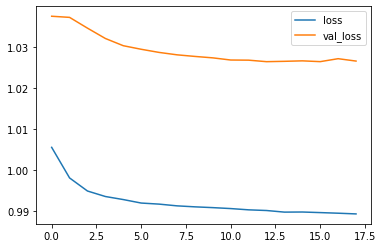

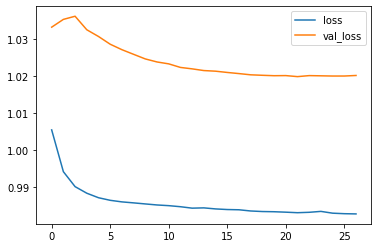

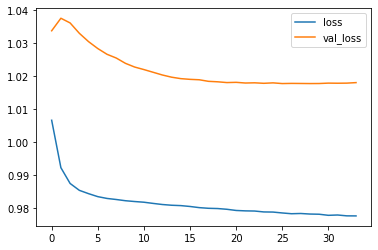

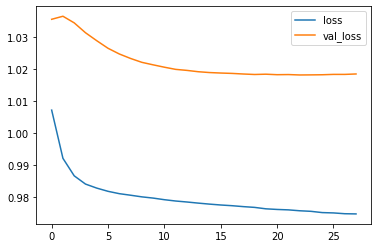

In [9]:
autoenc_simple_loss = list()

latent_space_size_list = list( np.arange(1, 20, 1) )
print( latent_space_size_list )

for latent_space_size in latent_space_size_list:
    
    print("Latent space size", latent_space_size)
    
    loss, fig = get_loss_autoencoder(get_simple_autoencoder, latent_space_size, 100, verbose = '0')
    fig
    
    autoenc_simple_loss.append( loss )

In [14]:
autoenc_simple_loss

[1.0265361803021866,
 1.0200642703957792,
 1.0181080119245698,
 1.0183674395714264]

In [ ]:
autoenc_simple_loss_relu_dict = dict()
autoenc_simple_loss_relu_dict["loss"] = autoenc_simple_loss
autoenc_simple_loss_relu_dict["dim"] = latent_space_size_list


dump_object("simple_autoencoder_loss_relu_finegrid", autoenc_simple_loss_dict)

In [101]:
autoenc_simple_loss_dict = dict()
autoenc_simple_loss_dict["loss"] = autoenc_simple_loss
autoenc_simple_loss_dict["dim"] = latent_space_size_list

In [102]:
import os
import pickle

dump_object("simple_autoencoder_loss_finegrid", autoenc_simple_loss_dict)

()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Latent space size 1
Model: "sequential_166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_454 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
dense_455 (Dense)            (None, 1, 64)             8256      
_________________________________________________________________
dense_456 (Dense)            (None, 1, 1)              65        
Total params: 1,416,577
Trainable params: 1,416,577
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_457 (Dense)            (None, 1, 64)             128       
_________________________________________________________

Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.8445416092743401
Latent space size 5
Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_478 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
dense_479 (Dense)            (None, 1, 64)             8256      
_________________________________________________________________
dense_480 (Dense)            (None, 1, 5)              325       
Total params: 1,416,837
Trainable params: 1,416,837
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_175"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_481 (Dense)         

Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.8225798591737876
Latent space size 9
Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_502 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
dense_503 (Dense)            (None, 1, 64)             8256      
_________________________________________________________________
dense_504 (Dense)            (None, 1, 9)              585       
Total params: 1,417,097
Trainable params: 1,417,097
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_183"
_________________________________________________________________
Layer (type)                 Output Shape            

Epoch 32/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.8231423196897584
Latent space size 13
Model: "sequential_190"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_526 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
dense_527 (Dense)            (None, 1, 64)             8256      
_________________________________________________________________
dense_528 (Dense)            (None, 1, 13)             845       
Total params: 1,417,357
Trainable params: 1,417,357
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_529 (Dense)            (None, 1, 64)             896       
_____________________________________

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.8193015124557759
Latent space size 18
Model: "sequential_200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_556 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
dense_557 (Dense)            (None, 1, 64)             8256      
_________________________________________________________________
dense_558 (Dense)            (None, 1, 18)             1170      

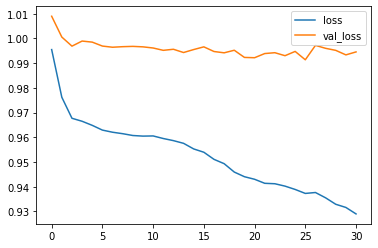

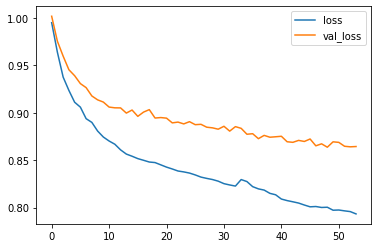

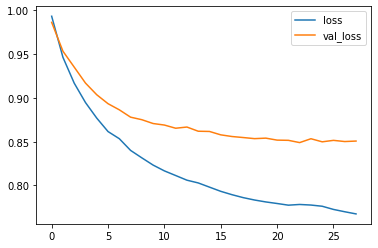

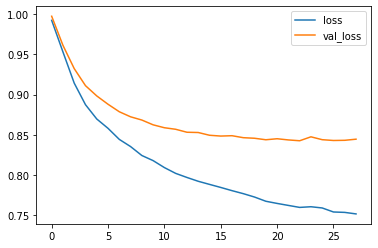

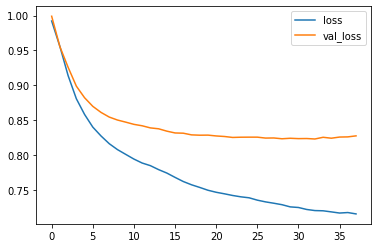

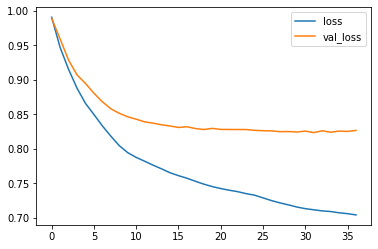

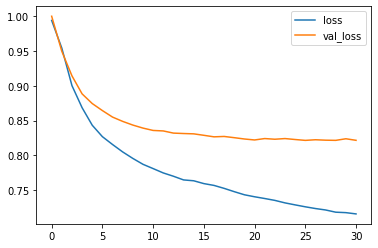

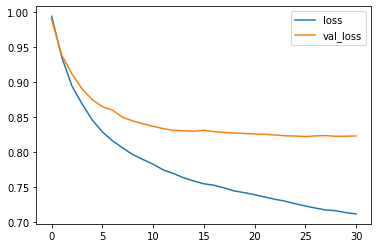

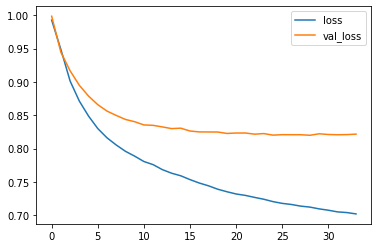

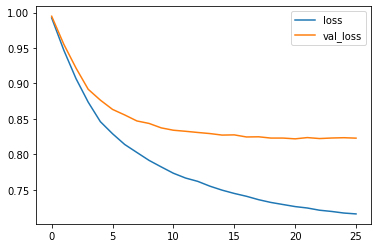

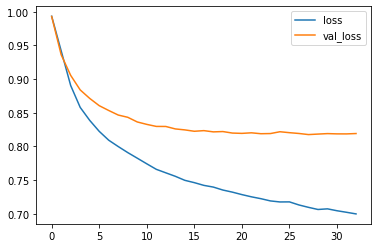

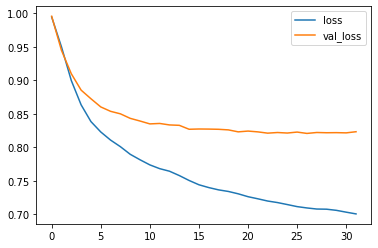

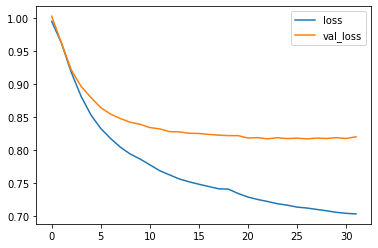

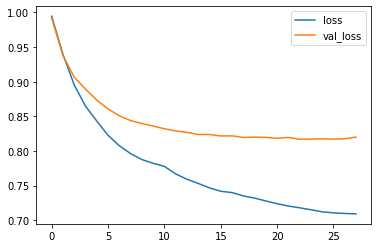

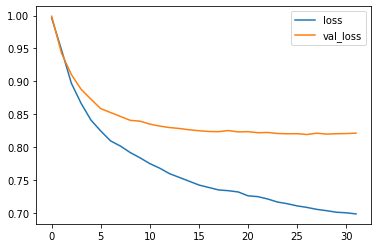

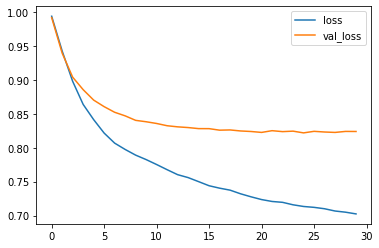

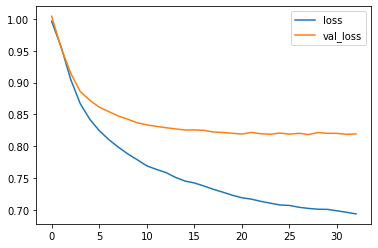

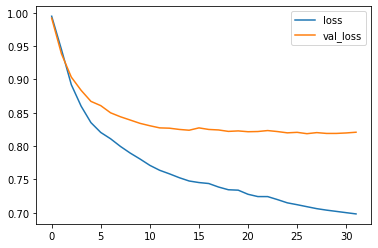

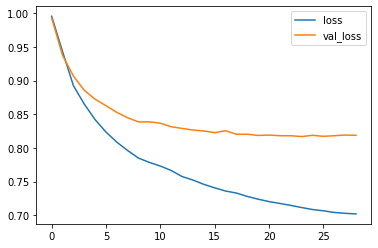

In [103]:
autoenc_6layer_loss = list()

latent_space_size_list = list( np.arange(1, 20, 1) )
print( latent_space_size_list )

for latent_space_size in latent_space_size_list:
    
    print("Latent space size", latent_space_size)
    
    loss, fig = get_loss_autoencoder(get_6layer_autoencoder, latent_space_size, 100, verbose = '0')
    fig
    
    autoenc_6layer_loss.append( loss )

In [104]:
autoenc_6layer_loss_dict = dict()
autoenc_6layer_loss_dict["loss"] = autoenc_6layer_loss
autoenc_6layer_loss_dict["dim"] = latent_space_size_list


In [105]:
import os

dump_object("6layer_autoencoder_loss_finegrid", autoenc_6layer_loss_dict)

()

In [124]:
autoenc_6layer_loss_dict["dim"]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

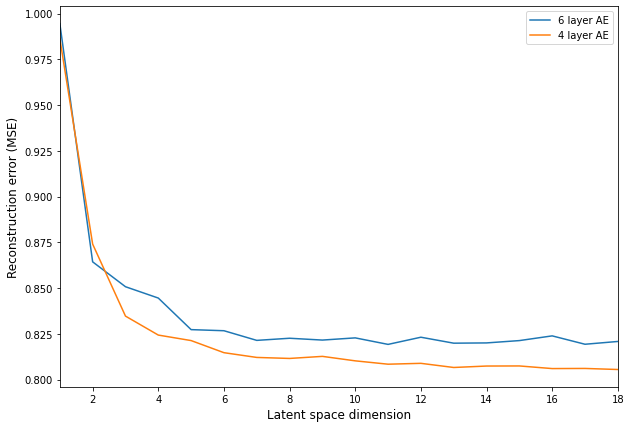

In [132]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(autoenc_6layer_loss_dict["dim"], autoenc_6layer_loss_dict["loss"], label = "6 layer AE")
ax.plot(autoenc_simple_loss_dict["dim"], autoenc_simple_loss_dict["loss"], label = "4 layer AE" )
ax.set_xlabel("Latent space dimension", fontsize = 12)
ax.set_ylabel("Reconstruction error (MSE)", fontsize = 12)
ax.set(xlim = (1,18) )
ax.legend();

## Pick one autoencoder and train it

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 264)            1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 50)             13250     
Total params: 2,918,834
Trainable params: 2,918,306
Non-trainable params: 528
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 264)            13464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 264)            1056      
_________________

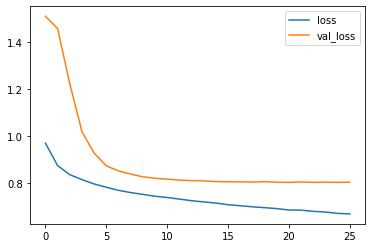

In [10]:
# Pick one model to train:

# autoencoder = get_simple_autoencoder(encoded_dim) 

encoder = Sequential([
    Dense(264, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l1(0)),
    BatchNormalization(),
    Dense(encoded_dim, activity_regularizer=regularizers.l1(0) ),
])
print(encoder.summary())

decoder = Sequential([
    Dense(264, input_shape = (1, encoded_dim), activation = 'relu', activity_regularizer=regularizers.l1(0)),
    BatchNormalization(),
    Dense(11001, activity_regularizer=regularizers.l1(0)),
])

print(decoder.summary())

autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 


epochs = 100
verbose = 'auto'

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

autoencoder.compile(loss = 'mean_squared_error', optimizer="Adam") # since output is zero or 1 use binary loss
# default optimiser: RMS propr
autoenc_history = autoencoder.fit(train_dataset, validation_data = test_dataset, epochs = epochs,
                                verbose = verbose, callbacks = earlystopping)

fig, ax = plt.subplots()
ax.plot(autoenc_history.history["loss"], label = "loss")
ax.plot(autoenc_history.history["val_loss"], label = "val_loss")
ax.legend()

print(fig)

x_predicted_val = autoencoder.predict(test_dataset)

print("Prediction shape", x_predicted_val.shape)

autoenc_loss = ((x_predicted_val.ravel() - x_val.numpy().ravel()) ** 2).sum().sum()/(x_val.numpy().size)
print("Loss:", autoenc_loss)

In [31]:
x_projected_autoenc_tensor = encoder(x_val)
x_projected_autoenc = x_projected_autoenc_tensor.numpy()[:, 0, :]

In [162]:
x_predicted_val = autoencoder.predict(test_dataset)[:, 0, :]
# x_reconstructed_autoenc = x_predicted_val.numpy()[:, 0, :]

In [167]:
autoenc_4layer = dict()
autoenc_4layer["x_original_val"] = x_val
autoenc_4layer["x_projected_val"] = x_projected_autoenc
autoenc_4layer["x_reconstructed_val"] = x_predicted_val
autoenc_4layer["autoenc_history"] = autoenc_history.history # dictionary with all useful info 
# autoenc_history.save('outputs/simple_autoenc_history')

In [168]:
import os
import pickle

dump_object("simple_autoenc_object", autoenc_4layer)

()

## Signal recovery

In [36]:
# wavelength (this comes from Jacob's email)
original_wavelengths = np.arange(900, 2000.01, 0.01) 

pooled_wavelength_stepsize = 0.01 * 10 # 10 is the pooling width
pooled_wavelengths = np.arange(900, 2000.01, pooled_wavelength_stepsize) 

In [34]:
# random.seed(2324)
random.seed(44223)
random_number_list = random.sample(range(x_val.shape[0]), 40, )

random_number_list = [273, 397]

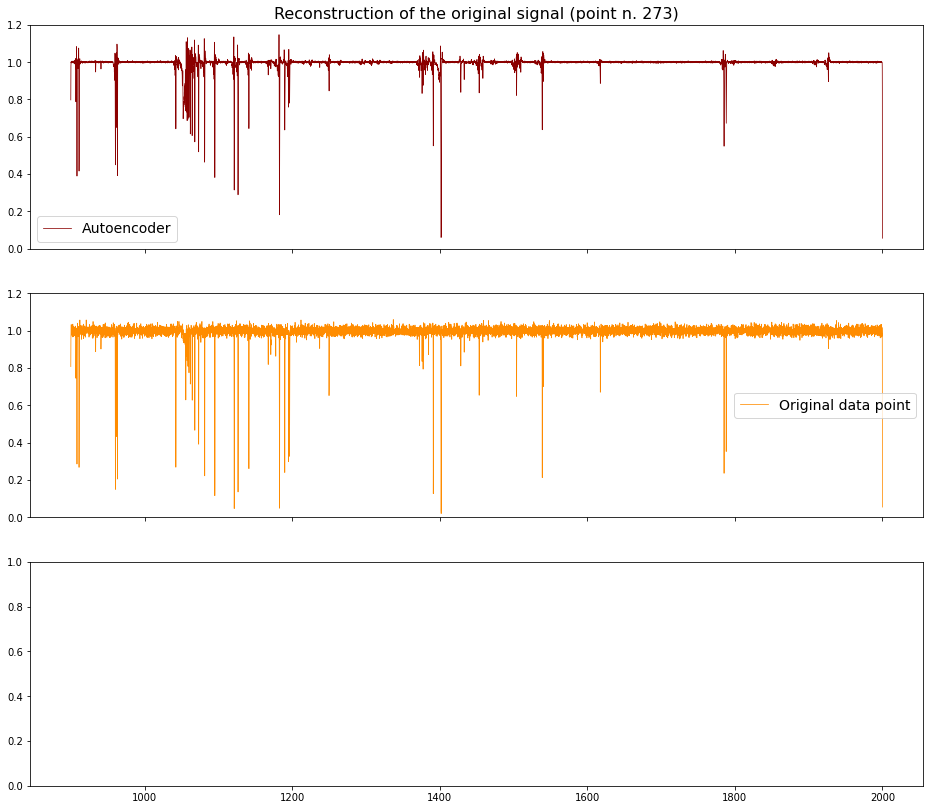

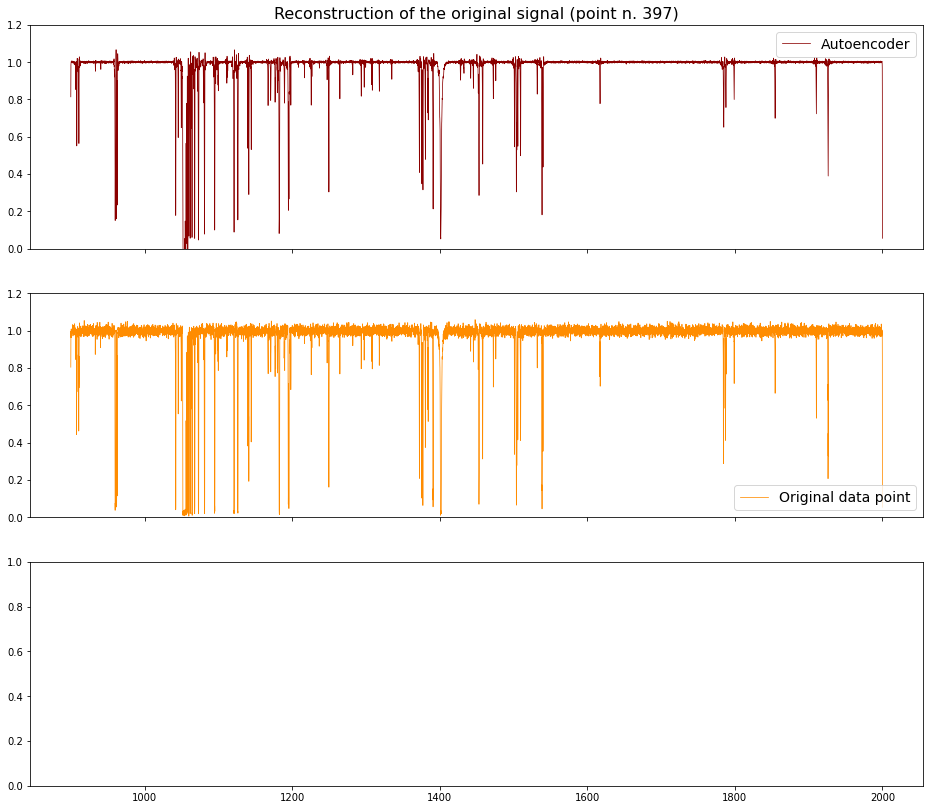

In [39]:
for random_number in random_number_list:
    x = tf.expand_dims(x_val[random_number, :], 1)
    x_projected = autoencoder.predict(x)
    x_projected_rescaled = rescale_back(x_projected, data_dict["parameters"]["mean"], data_dict["parameters"]["std"]) 
    
    x_true_rescaled = x = rescale_back(x, data_dict["parameters"]["mean"], data_dict["parameters"]["std"]) 
    
    fig, ax = plt.subplots(3, 1, sharex = True, figsize = (16, 14))
    ax[0].plot(pooled_wavelengths, x_projected_rescaled[0][0], label = "Autoencoder", linewidth = 0.75, color = "darkred")
    ax[0].legend(fontsize = 14)
    ax[0].set_ylim([0,1.2])
    
    ax[1].plot(pooled_wavelengths, x_true_rescaled[0][0], label = "Original data point", linewidth = 0.75, color = "darkorange")
    ax[1].legend(fontsize = 14)
    ax[1].set_ylim([0,1.2])
    
    ax[0].set_title("Reconstruction of the original signal (point n. " + str(random_number) + ")",
                   fontsize = (16));

In [20]:
x_true_rescaled[0]

<tf.Tensor: shape=(1, 11001), dtype=float64, numpy=
array([[0.83581351, 0.98055883, 0.98352094, ..., 0.94135246, 0.84773214,
        0.05637673]])>

In [26]:
x_val

<tf.Tensor: shape=(430, 1, 11001), dtype=float64, numpy=
array([[[0.80113647, 0.95586027, 0.97438402, ..., 0.99469935,
         0.83811596, 0.05806611]],

       [[0.79262418, 0.94985584, 1.00928017, ..., 0.94714131,
         0.84335409, 0.05996814]],

       [[0.81750669, 0.96579348, 0.98094038, ..., 0.96590885,
         0.86320455, 0.05987717]],

       ...,

       [[0.79855481, 0.92693663, 0.9840565 , ..., 0.96724595,
         0.83844514, 0.05654658]],

       [[0.80103545, 0.97278253, 0.99427281, ..., 0.95928068,
         0.85912315, 0.04893462]],

       [[0.83913666, 0.9643553 , 0.97546815, ..., 0.95498882,
         0.82907042, 0.04924526]]])>

In [13]:
xxx = tf.expand_dims(x_train[1102, :], 1)

def rescale_back(observation, mean, std):
    return( observation*std + mean ) 

In [97]:
x_train.shape

TensorShape([1346, 1, 11001])

In [99]:
xxx_projected = cnn_autoencoder.predict(xxx)

NameError: name 'cnn_autoencoder' is not defined

In [83]:
xxx_projected_rescaled = rescale_back(xxx_projected, data_dict["parameters"]["mean"], data_dict["parameters"]["std"]) 

In [84]:
xxx_projected_rescaled[0][0]

array([0.79283696, 0.94636379, 0.97699706, ..., 0.96231329, 0.84189817,
       0.05623051])

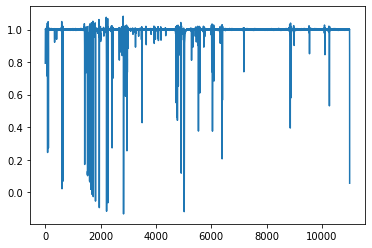

In [85]:
fig, ax = plt.subplots()
ax.plot(xxx_projected_rescaled[0][0])

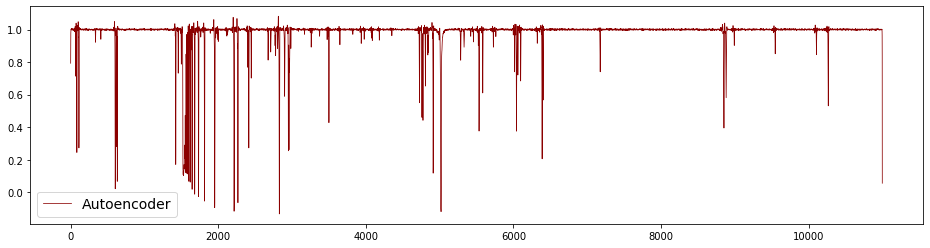

In [93]:
fig, ax = plt.subplots(figsize = (16, 4))
ax.plot(xxx_projected_rescaled[0][0], label = "Autoencoder", linewidth = 0.75, color = "darkred")
ax.legend(fontsize = 14)

In [56]:
help(dump_object)

Help on function dump_object in module __main__:

dump_object(object_name, object_tosave)
    Saves a given object under a given name in directory ./outputs (if such directory
    does not exist the function creates it.



In [135]:
# Predict and evlauate: on the full validation set

x_predicted_val = cnn_autoencoder.predict(test_dataset)

autoenc_loss = ((x_predicted_val.ravel() - x_val.numpy().ravel()) ** 2).sum().sum()/(x_val.numpy().size)

print(np.around(autoenc_loss))

NameError: name 'cnn_autoencoder' is not defined

In [25]:
np.abs(x_predicted_val).sum()

1039413.2

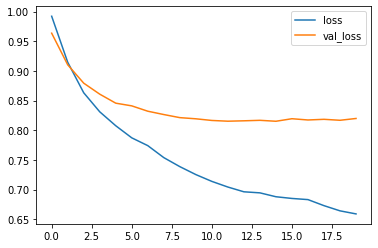

In [27]:
fig, ax = plt.subplots()
ax.plot(cnn_histoy.history["loss"], label = "loss")
ax.plot(cnn_histoy.history["val_loss"], label = "val_loss")
ax.legend()

### Overparametrized

## Timeseries Autoencoder

In [28]:
from tensorflow import keras

timesteps = x_train.shape[1]
input_dim = 1 #x_train.shape[0]
latent_dim = 50

inputs = keras.Input(shape=(timesteps, input_dim) )
encoded = keras.layers.LSTM(latent_dim)(inputs)

decoded = keras.layers.RepeatVector(timesteps)(encoded)
decoded = keras.layers.LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = keras.Model(inputs, decoded)
encoder = keras.Model(inputs, encoded)


# sequence_autoencoder = keras.Model(input_img, decoded)
sequence_autoencoder.compile(optimizer='adam', loss='mean_squared_error')


# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# https://blog.keras.io/building-autoencoders-in-keras.html
sequence_autoencoder.fit(x_train, x_train,
                epochs=1,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))
#                 callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

# https://medium.com/red-buffer/autoencoders-guide-and-code-in-tensorflow-2-0-a4101571ce56
# https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

ValueError: in user code:

    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\functional.py:420 call
        return self._run_internal_graph(
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:668 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\jbryb\gsof_env\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer lstm_4: expected shape=(None, None, 1), found shape=(None, 1, 11001)


In [160]:
x_train.to_numpy().shape

(1346, 11001)

In [65]:
data_dict.keys()

dict_keys(['x', 'x_pooled', 'y', 'parameters'])

In [66]:
def rescale_back(observation, mean, std):
    return( observation*std + mean ) 